## Improving Quantum Circuit performance with TKET on H-Series devices and other platforms

#### Estimating Two-Qubit Gater Error

$ \% \text{Error}_{2QG} = (1-\text{Fidelity}^N) \times 100\% $

where $N$ i the number of two qubit gates in system.

Examples:

$100$ 2QGs with the fidelity of $0.993$, which means the error% of $=(1-0.993^{100}) \times 100\% = 50\%$

$100$ 2QGs with the fidelity of $0.998$, which means the error% of $=(1-0.998^{100}) \times 100\% = 18\%$

$100$ 2QGs with the fidelity of $0.998$, which means the error% of $=(1-0.999^{100}) \times 100\% = 9.5\%$



![alt text](img.png "2 Qubit Gate Fidelity")

## TKET Extensions

![alt text](img2.png "Title")

## TKET has a default pass manager for each backend

`get_compiled_circuit(circuit,optimization_level)`

![alt text](img3.png "Title")

In [2]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-1'

backend = QuantinuumBackend(device_name = machine)
backend.login()

In [3]:
print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1 status:  online


In [4]:
[x.device_name for x in QuantinuumBackend.available_devices()]

['H1-1SC', 'H1-1E', 'H1-1']

## Importing a Circuit from QIskit

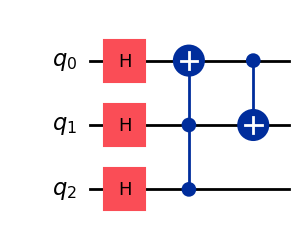

In [5]:
from qiskit import QuantumCircuit

qiskit_circuit = QuantumCircuit(3)
qiskit_circuit.h(range(3))
qiskit_circuit.ccx(2,1,0)
qiskit_circuit.cx(0,1)
qiskit_circuit.draw(output='mpl',style='iqx')

In [6]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter # necessary to visualize circuits in Jupyter
tket_circ = qiskit_to_tk(qiskit_circuit)    
render_circuit_jupyter(tket_circ)

### Using Backends

In [7]:
from pytket import Circuit

ghz_circ = Circuit(3)
ghz_circ.H(0)
ghz_circ.CX(0, 1)
ghz_circ.CX(1, 2)
ghz_circ.add_barrier(ghz_circ.qubits)
ghz_circ.measure_all()
render_circuit_jupyter(ghz_circ)

### Running on qiskit simulator

In [21]:


from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
result = backend.run_circuit(ghz_circ)
print(result.get_counts())



Counter({(0, 0, 0): 540, (1, 1, 1): 484})


In [29]:
from qiskit.visualization import plot_histogram

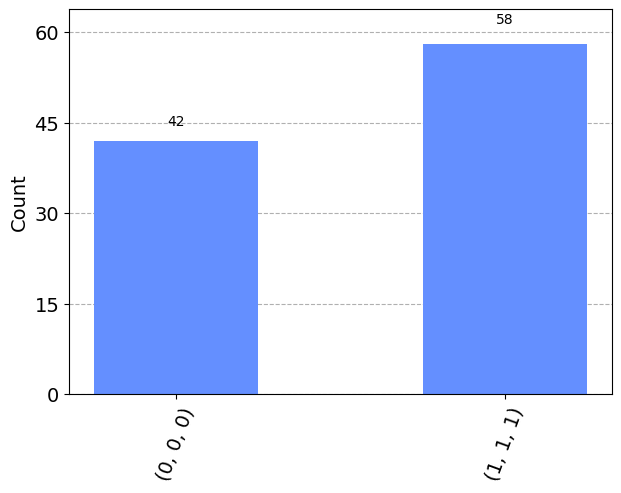

In [30]:
plot_histogram(result.get_counts())

#### Running on Quantinuum Simulator

In [31]:
machine = 'H1-1E'

backend = QuantinuumBackend(device_name = machine)

print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1E status:  online


Well there's no need to compile it, but we'll do it anyways

In [32]:
compiled_circ = backend.get_compiled_circuit(ghz_circ,optimisation_level=2)
render_circuit_jupyter(compiled_circ)

Let's see how much will it cost to run on actual quantum hardware

In [33]:
n_shots = 100
backend.cost(compiled_circ, n_shots=n_shots, syntax_checker='H1-1E')

6.1

Let's run it on Simulator

In [34]:
handle = backend.process_circuit(compiled_circ, n_shots=n_shots)

print(handle)

status = backend.circuit_status(handle)
print(status)

('135ef93f6f494507a582b88a2641abd7', 'null', 3, '[["c", 0], ["c", 1], ["c", 2]]')
CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "job", "submit-date": "2023-12-19T09:29:10.389266", "result-date": null, "queue-position": null, "cost": "6.1", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [35]:
result = backend.get_result(handle)
print(result.get_counts())

Counter({(0, 0, 0): 56, (1, 1, 1): 44})


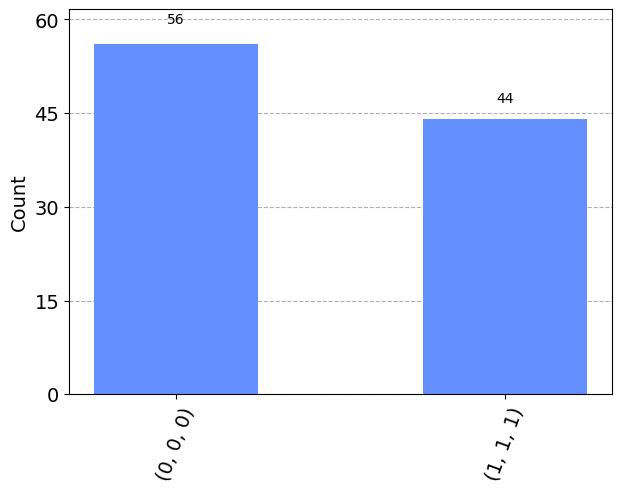

In [36]:
plot_histogram(result.get_counts())

### This is how you save the result in quantinuum

In [37]:
import json
with open('ghz.json', 'w') as f:
    json.dump(result.to_dict(), f)

In [38]:
from pytket.backends.backendresult import BackendResult

with open('ghz.json', 'r') as f:
    data = json.load(f)

result = BackendResult.from_dict(data)

In [39]:
result = backend.get_result(handle)
print(result.get_counts())
print(result.get_distribution())


Counter({(0, 0, 0): 56, (1, 1, 1): 44})
{(0, 0, 0): 0.56, (1, 1, 1): 0.44}


## More such comparisons